In [1]:
%matplotlib inline

import pandas
import numpy
import sklearn
from sklearn import metrics, datasets, model_selection

import sys
sys.path.insert(0, 'build/lib.linux-x86_64-3.6/')
import naivebayes
import embayesc

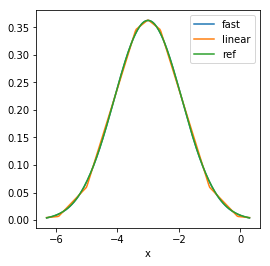

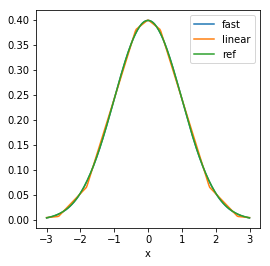

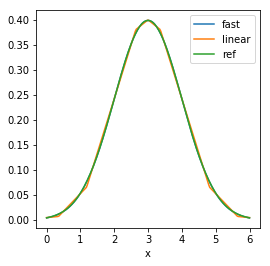

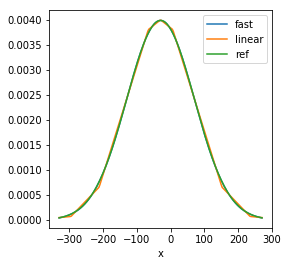

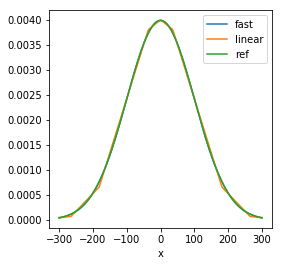

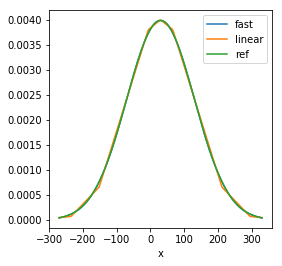

In [4]:
np = numpy

def prob_scipy(x, mean, std):
    return scipy.stats.norm.pdf(x, mean, std)

def prob_ref(x, mean, std):
    exponent = np.exp(- ((x - mean)**2 / (2 * std**2)))
    return (exponent / (np.sqrt(2 * np.pi) * std))

def prob_fast(x, mean, std):
    if numpy.isscalar(x):
        x = [x]
    v = [ embayesc.pdf_fast(xx, mean, std) for xx in x]
    return numpy.array(v)

def prob_linear(x, mean, std):
    if numpy.isscalar(x):
        x = [x]
    v = [ embayesc.pdf_linear4(xx, mean, std) for xx in x]
    return numpy.array(v)
    
def compare_p(mean=0.0, std=1.0, sigma=3.0):
    samples = numpy.linspace(mean-(sigma*std), mean+(sigma*std), 200)

    ref = prob_ref(samples, mean, std)
    fast = prob_fast(samples, mean, std)
    linear = prob_linear(samples, mean, std)
    
    df = pandas.DataFrame({
        'x': samples,
        'ref': ref,
        'fast': fast,
        'linear': linear,
    })
    df.plot(x='x', figsize=(4,4))

checks = ([-3.0, 0.0, 3.0, -30.0, 0.0, 30.0], [1.1, 1.0, 1.0, 100.1, 100.1, 100.1])
#checks = ([0.0], [1.0])
for mean, std in zip(*checks):
    compare_p(mean, std)

const float x0 = 0.36162074642908926;
const float x1 = 1.8155589902937184;
const float x2 = 2.648057827038413;
const float aaa = 0.03206602865801561;
const float aa = 0.073039824220558;
const float a = -0.0812669530595659;
const float b = -0.030153898298411575;
const float c = 0.21203273664616568;


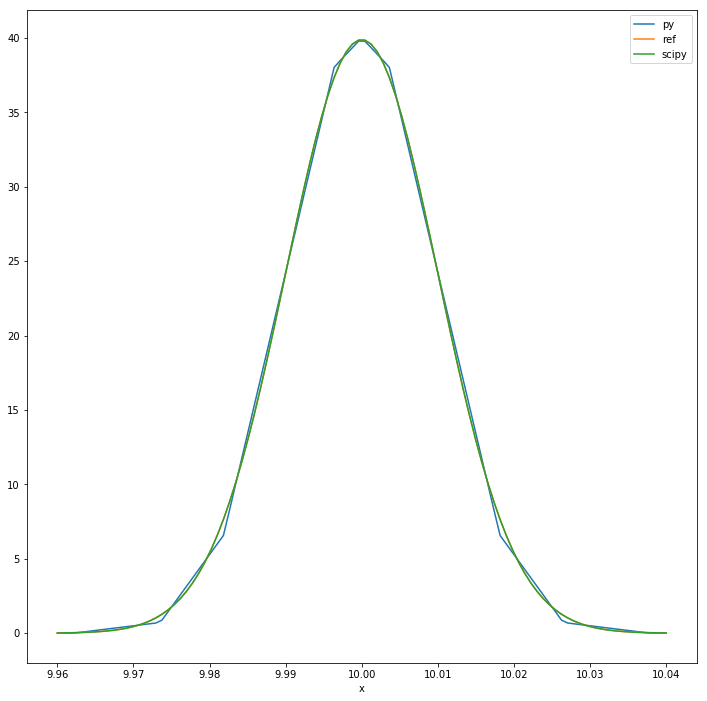

In [6]:
import scipy.stats

def piecewise_linear2(x, x0, a, b, c):
    y = a*np.abs(x-x0) + b*x + c
    return y

def piecewise_linear3(x, x0, x1, aa, a, b, c):
    y = aa*np.abs(x-x1) + a*np.abs(x-x0) + b*x + c
    return y

def piecewise_linear4(x, x0, x1, x2, aaa, aa, a, b, c):
    y = aaa*np.abs(x-x2) + aa*np.abs(x-x1) + a*np.abs(x-x0) + b*x + c
    return y

def c_constants(kw, ctype='const float'):
    v = ("{} {} = {};".format(ctype, k, v) for k,v in kw.items())
    return '\n'.join(v)

from scipy.optimize import curve_fit
fitx = numpy.linspace(0, 4, 30)
fity = prob_ref(fitx, 0.0, 1.0)
p0 = [0.5, 2.0, 3.14, 1000, 1000, 1000, 1000, 1000]
pnames = ['x0', 'x1', 'x2', 'aaa', 'aa', 'a', 'b', 'c']
popt_piecewise, pcov = curve_fit(piecewise_linear4, fitx, fity, p0=p0)

def prob_linear_py(x, mean, std):
    xm = (x - mean) / (std)    
    if xm < 0:
        xm = -xm
    p = piecewise_linear4(xm, *popt_piecewise) / std
    #print(p)
    #return p
    if p < 0.00001:
        return 0.00001
    return p

mean, std = 10, 0.01
sigma = 4
points = numpy.linspace(mean-(sigma*std), mean+(sigma*std), 100)
df = pandas.DataFrame({
    'x': points,
    'ref': prob_ref(points, mean, std),
    'scipy': 0.0005+prob_scipy(points, mean, std),
    'py': [ prob_linear_py(p, mean, std) for p in points ],
    #'c': [ prob_linear(p, mean, std) for p in points ],
}).plot(x='x', figsize=(12,12))

vals = dict(zip(pnames, popt_piecewise))
print(c_constants(vals))

## Approximate logarithmic prob

const float x0 = 0.8333333885368039;
const float x1 = 2.0114942763546977;
const float x2 = 3.4195402297818958;
const float aaa = -1.1193323517431;
const float aa = -0.9327769306872999;
const float a = -0.746221586714255;
const float b = -3.295811966758346;
const float c = 5.042867068181607;


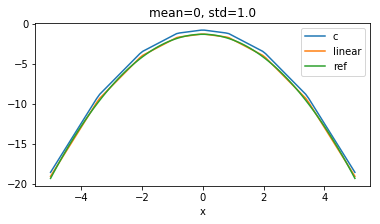

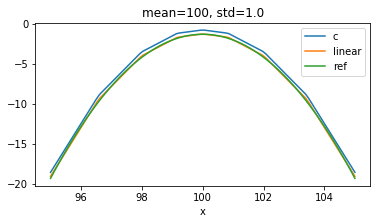

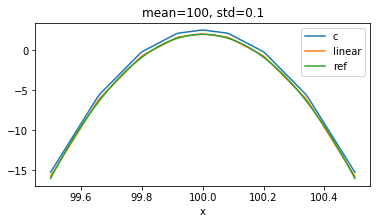

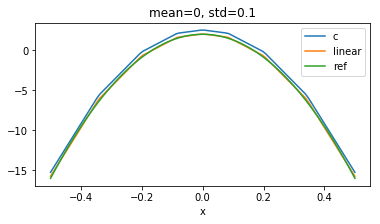

In [11]:
from scipy.optimize import curve_fit

def logprob_ref(x, mean, std):
    return numpy.log2(prob_ref(x, mean ,std))

fitx = numpy.linspace(0, 5, 30)
fity = logprob_ref(fitx, 0.0, 1.0)
p0 = [0.5, 2.0, 3.14, 0, 0, 0, 0, 0]
pnames = ['x0', 'x1', 'x2', 'aaa', 'aa', 'a', 'b', 'c']
popt_piecewise, pcov = curve_fit(piecewise_linear4, fitx, fity, p0=p0)

def logprob_fit(x, mean, std):
    xm = (x - mean) / (std)    
    if xm < 0:
        xm = -xm
    p = piecewise_linear4(xm, *popt_piecewise) - numpy.log2(std)
    return p

vals = dict(zip(pnames, popt_piecewise))
print(c_constants(vals))

def prob_loglin(x, mean, std):
    stdlog2 = numpy.log2(std)
    if numpy.isscalar(x):
        x = [x]
    v = [ embayesc.pdf_loglin4(xx, mean, std, stdlog2) for xx in x]
    return numpy.array(v)

sigma = 5
means, stds = ((0, 100, 100, 0), (1.0, 1.0, 0.1, 0.1))
for mean, std in zip(means, stds):
    start = mean-(sigma*std)
    points = numpy.linspace(start, mean+(sigma*std), 100)
    ref = logprob_ref(points, mean, std)
    fit = [ logprob_fit(p, mean, std) for p in points ]
    c = prob_loglin(points, mean, std) + 0.5
    df = pandas.DataFrame({
        'x': points,
        'ref': ref,
        'c': c,
        'linear': fit,
    }).plot(x='x', figsize=(6,3), title='mean={}, std={}'.format(mean, std))


/usr/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


const float a = -0.7213475204444817;
const float b = -1.0005845727355313e-15;
const float c = -1.3257480647361592;


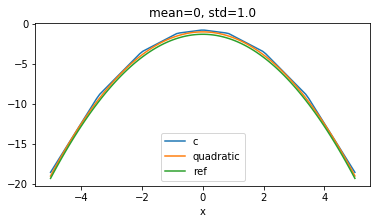

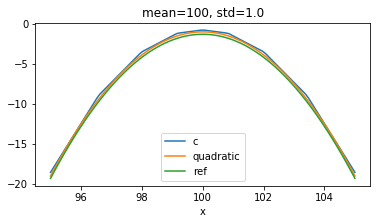

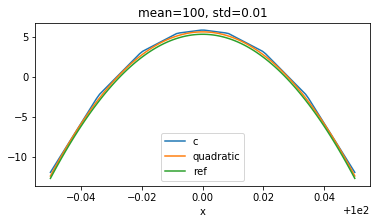

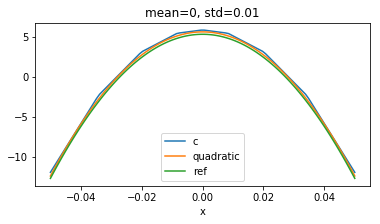

In [24]:
def quadratic(x, a, b, c):
    return a*(x**2) + b*x + c

fitx = numpy.linspace(-5, 5, 30)
fity = logprob_ref(fitx, 0.0, 1.0)
p0 = [0, 0, 0]
pnames = ['a', 'b', 'c']
popt_quadratic, pcov = curve_fit(quadratic, fitx, fity, p0=p0)

vals = dict(zip(pnames, popt_quadratic))
print(c_constants(vals))

def p_q(x, mean, std):
    xm = (x - mean) / (std)
    p = quadratic(xm, *popt_quadratic) - numpy.log2(std)
    return p + 0.3
    
def prob_loglin_quadratic(x, mean, std):
    if numpy.isscalar(x):
        x = [x]
    v = [ p_q(xx, mean, std) for xx in x ]
    return numpy.array(v)

sigma = 5
means, stds = ((0, 100, 100, 0), (1.0, 1.0, 0.01, 0.01))
for mean, std in zip(means, stds):
    start = mean-(sigma*std)
    points = numpy.linspace(start, mean+(sigma*std), 100)

    ref = logprob_ref(points, mean, std)
    fit = prob_loglin_quadratic(points, mean, std)
    
    c = prob_loglin(points, mean, std) + 0.5
    df = pandas.DataFrame({
        'x': points,
        'ref': ref,
        'c': c,
        'quadratic': fit,
    }).plot(x='x', figsize=(6,3), title='mean={}, std={}'.format(mean, std))


In [4]:
class GaussianNB(object):
    def __init__(self):
        pass

    def fit(self, X, y):
        separated = [[x for x, t in zip(X, y) if t == c] for c in np.unique(y)]
        self.model = np.array([np.c_[np.mean(i, axis=0), np.std(i, axis=0)] for i in separated])
        return self

    def _prob(self, x, mean, std):
        return np.log(prob_ref(x, mean, std))

    def predict_log_proba(self, X):            
        def class_probability(summaries, x):
            probs = [self._prob(i, *s) for s, i in zip(summaries, x)]
            ss = sum(probs)
            sss = numpy.sum(probs)
            return sss
                
        return [[ class_probability(s, x) for s in self.model] for x in X]

            
        #return [[  sum(self._prob(i, *s) for s, i in zip(summaries, x))
        #        for summaries in self.model] for x in X]

    def predict(self, X):
        n_classes, n_features, _ = self.model.shape
        model = list(numpy.ravel(self.model))
        self.classifier = naivebayes.Classifier(model, n_classes, n_features)

        cp = [ self.classifier.predict(x) for x in X ]
        pp = np.argmax(self.predict_log_proba(X), axis=1)
        print('predictions', cp, '\n', pp)
        return pp

    def score(self, X, y):
        return sum(self.predict(X) == y) / len(y)
    
class GaussianCos(GaussianNB):
    def _prob(self, x, mean, std):
        return np.log(prob_cos(x, mean, std))
    
class GaussianTaylor(GaussianNB):
    def _prob(self, x, mean, std):
        return np.log(prob_taylor(x, mean, std))
    
class GaussianFixed(GaussianNB):
    def _prob(self, x, mean, std):
        return np.log(prob_fixed(x, mean, std))
    
class GaussianFast(GaussianNB):
    def _prob(self, x, mean, std):
        return np.log(prob_fast(x, mean, std))
    
class GaussianLinear(GaussianNB):
    def _prob(self, x, mean, std):
        return np.log(prob_linear(x, mean, std))
    

In [5]:
# Data
data = datasets.load_breast_cancer()
label_names = data['target_names']
labels = data['target']
feature_names = data['feature_names']
features = data['data']

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

S = model_selection.train_test_split(features, labels, test_size=0.33, random_state=42)
train, test, train_labels, test_labels = S
classifiers = [
    GaussianNB(),
    #GaussianFast(),
    #GaussianCos(),
    #GaussianFixed(),
    #GaussianLinear(),
]
acc = []
for estimator in classifiers:
    # Train
    s  = StandardScaler()
    gnb = estimator
    train = s.fit_transform(train)
    model = gnb.fit(train, train_labels)
    #print(model.model.shape, train.shape)
    #print(model.model)
    # Tests
    test = s.transform(test)
    preds = gnb.predict(test)
    acc.append(metrics.accuracy_score(test_labels, preds))

print(acc)

predictions [1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1] 
 [1 0 0 1 1 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0
 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0
 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 1 1 0
 1 1 0 0 0 1 1 1 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0
 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0
 0 0 1]
[0.9308510638297872]
